<a href="https://colab.research.google.com/github/hibiki-iwanaga/pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリインポートするしかないんちゃいますん?

In [3]:
import time
import numpy as np
import pandas as pd
 
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
 
from sklearn.model_selection import train_test_split
 
import matplotlib.pyplot as plt
%matplotlib inline

## データセットどんな感じか確認しとかなあかんのちゃいまっか？

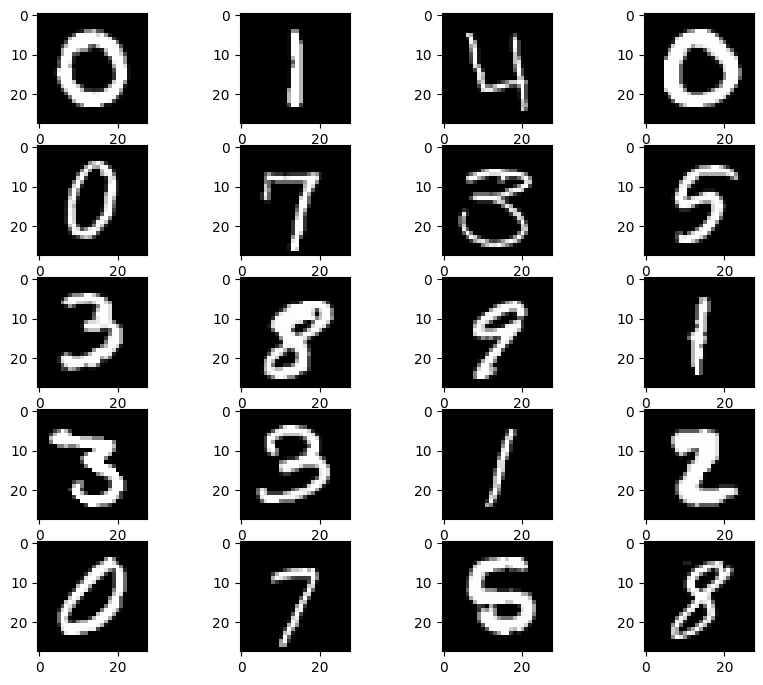

In [4]:
from PIL import Image
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/mnist/mnist/train.csv', delimiter=',').to_numpy()
df = df[1:]
X = df[:,1:]
X = X / 255
new_X = []
for i in range(len(X)):
    new_X.append(X[i].reshape(28,28))
X = new_X
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(10,10)) 
    for i, img in enumerate(datset):
        if i == num_samples:
            break
        image = Image.fromarray(img * 255)
        plt.subplot(int(num_samples/cols + 1), cols, i + 1)
        plt.imshow(image)

show_images(X)

## 機械学習モデルに学習させるためのデータセット読み込んじゃいます

In [5]:
train = pd.read_csv('./drive/MyDrive/Colab Notebooks/mnist/mnist/train.csv') 
X = train.drop('label', axis=1).values
y = train.label.values
X = X.reshape(-1, 1, 28, 28)
X = X/255
 
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)
 
    

train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.int64) 
 
val_X= torch.tensor(val_X, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.int64) 
 
train_set = torch.utils.data.TensorDataset(train_X,train_y)
test_set = torch.utils.data.TensorDataset(val_X, val_y)
 
batch_sizes =128   

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_sizes, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_sizes, shuffle = False)

# CNN(Convolutional Neural Network)
## 畳み込みニューラルネットワーク

マスターなってまうしかないんとちゃいますん？

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #畳み込み層
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Dropout(p=0.25)
        )
        #全結合層
        self.dence = nn.Sequential(
            nn.Linear(64 * 3 *3, 256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10)
        )
 
    #順伝播
    def forward(self,x):
         
        out = self.conv_layers(x)
        #Flatten
        out = out.view(out.size(0), -1)
        #全結合層
        out = self.dence(out)
         
        return out
     
    #畳み込み層の出力サイズのチェック
    def check_cnn_size(self, size_check):
        out = self.conv_layers(size_check)
         
        return out

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #GPU割り当て
net = CNN().to(device)

In [9]:
size_check = torch.FloatTensor(10, 1, 28, 28)
size_check = size_check.to(device)
print(net.check_cnn_size(size_check).size())

torch.Size([10, 64, 3, 3])


In [10]:
#損失関数
criterion = nn.CrossEntropyLoss()
#最適化
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


In [11]:
num_epochs =30
 
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
     
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net.forward(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
     
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
     
    #val
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net.forward(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
     
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


    
print(time.time() - start)

Epoch [1/30], Loss: 0.0096, val_loss: 0.0017, val_acc: 0.9352
Epoch [2/30], Loss: 0.0017, val_loss: 0.0009, val_acc: 0.9651
Epoch [3/30], Loss: 0.0011, val_loss: 0.0006, val_acc: 0.9751
Epoch [4/30], Loss: 0.0008, val_loss: 0.0005, val_acc: 0.9789
Epoch [5/30], Loss: 0.0007, val_loss: 0.0005, val_acc: 0.9807
Epoch [6/30], Loss: 0.0006, val_loss: 0.0004, val_acc: 0.9796
Epoch [7/30], Loss: 0.0005, val_loss: 0.0004, val_acc: 0.9820
Epoch [8/30], Loss: 0.0005, val_loss: 0.0003, val_acc: 0.9868
Epoch [9/30], Loss: 0.0005, val_loss: 0.0003, val_acc: 0.9862
Epoch [10/30], Loss: 0.0004, val_loss: 0.0003, val_acc: 0.9868
Epoch [11/30], Loss: 0.0004, val_loss: 0.0003, val_acc: 0.9886
Epoch [12/30], Loss: 0.0004, val_loss: 0.0003, val_acc: 0.9867
Epoch [13/30], Loss: 0.0003, val_loss: 0.0003, val_acc: 0.9875
Epoch [14/30], Loss: 0.0003, val_loss: 0.0003, val_acc: 0.9886
Epoch [15/30], Loss: 0.0003, val_loss: 0.0003, val_acc: 0.9894
Epoch [16/30], Loss: 0.0003, val_loss: 0.0003, val_acc: 0.9874
E

# なんやよーわからんけどこれで学習が完了しちゃっとります。


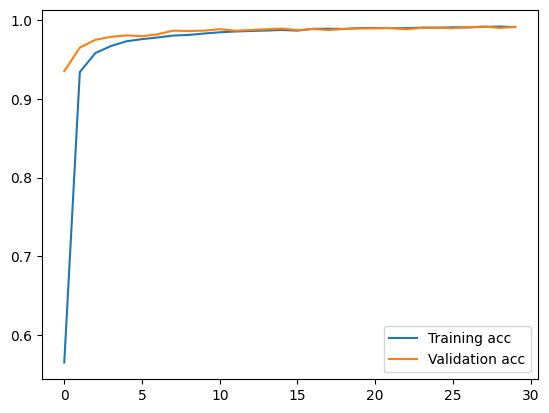

In [12]:
plt.plot(train_acc_list, label='Training acc')
plt.plot(val_acc_list, label='Validation acc')
plt.legend()

In [13]:
test = pd.read_csv('./drive/MyDrive/Colab Notebooks/mnist/mnist/test.csv')
test = test.values
test = test.reshape(-1, 1, 28, 28)
test = test/255
 
batch_sizes = 1
test = torch.tensor(test, dtype=torch.float32)
test_sets = torch.utils.data.TensorDataset(test)
new_test_loader = torch.utils.data.DataLoader(test, batch_size = batch_sizes, shuffle = False)


In [14]:
pred_list = []
start = time.time()
with torch.no_grad():
    net.eval()
    c = 0
    for images in new_test_loader:
        images = images.to(device)
        output = net.forward(images)
        _, pred = torch.max(output.data, 1) 
        pred_list.append(pred.item())
print(time.time() - start)

27.994969367980957


In [ ]:
pred_list = np.array(pred_list)
ID_lists= np.arange(1, pred_list.shape[0]+1) 
 
submissions=pd.DataFrame({"ImageId": ID_lists,
                         "Label": pred_list})
submissions.to_csv('./drive/MyDrive/Colab Notebooks/mnist/mnist/submission.csv', index=False, header=True)
